### **Exploratory Data Analysis**

In [1]:
# IMPORTS

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kendalltau, chi2_contingency
import seaborn as sns

In [2]:
# LOAD DATASET

df = pd.read_csv("drug_consumption.csv")
# Remove records claiming use of "Semeron" (fake drug to identify drug seekers)
df = df[df['semer'] == 'CL0']
feature_file_dict = {f"{feat}":f"additional-variable-information/{i}-{feat}.csv" for i,feat in enumerate(df.columns.to_list())}
# Categorize all feature variables by data types
all_vars = df.columns.tolist()
nominal_vars = ['gender', 'country', 'ethnicity']
ordinal_vars = ['age', 'education', 'alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 
    'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 
    'mushrooms', 'nicotine', 'vsa']
demographic_vars = ['age', 'gender', 'education', 'country', 'ethnicity']
ffi_vars = ['n_score', 'e_score', 'o_score', 'a_score', 'c_score']
personality_vars = ['n_score', 'e_score', 'o_score', 'a_score', 'c_score',
    'impulsive_bis11', 'sensation_seeking_impss']
drug_vars = ['alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 
    'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh', 
    'lsd', 'meth', 'mushrooms', 'nicotine', 'vsa']

#### **Initial Visualizations**

In [3]:
# CONVERT INPUT FEATURE VALUES TO MEANINGS (FOR READABILITY)

# Convert input_df feature values with each variable value's corresponding meaning
for var_dem in demographic_vars:
    df_var = pd.read_csv(feature_file_dict[var_dem], usecols=['Value', 'Meaning'])
    value_meanings = pd.Series(df_var['Meaning'].values, index=df_var['Value']).to_dict()
    df[var_dem] = df[var_dem].map(value_meanings)
for score in ffi_vars:
    score_col = f"{score[0].capitalize()}score"
    df_score = pd.read_csv(feature_file_dict[score], usecols=[score_col, 'Value'])
    value_scores = pd.Series(df_score[score_col].values, index=df_score['Value']).to_dict()
    df[score] = df[score].map(value_scores)

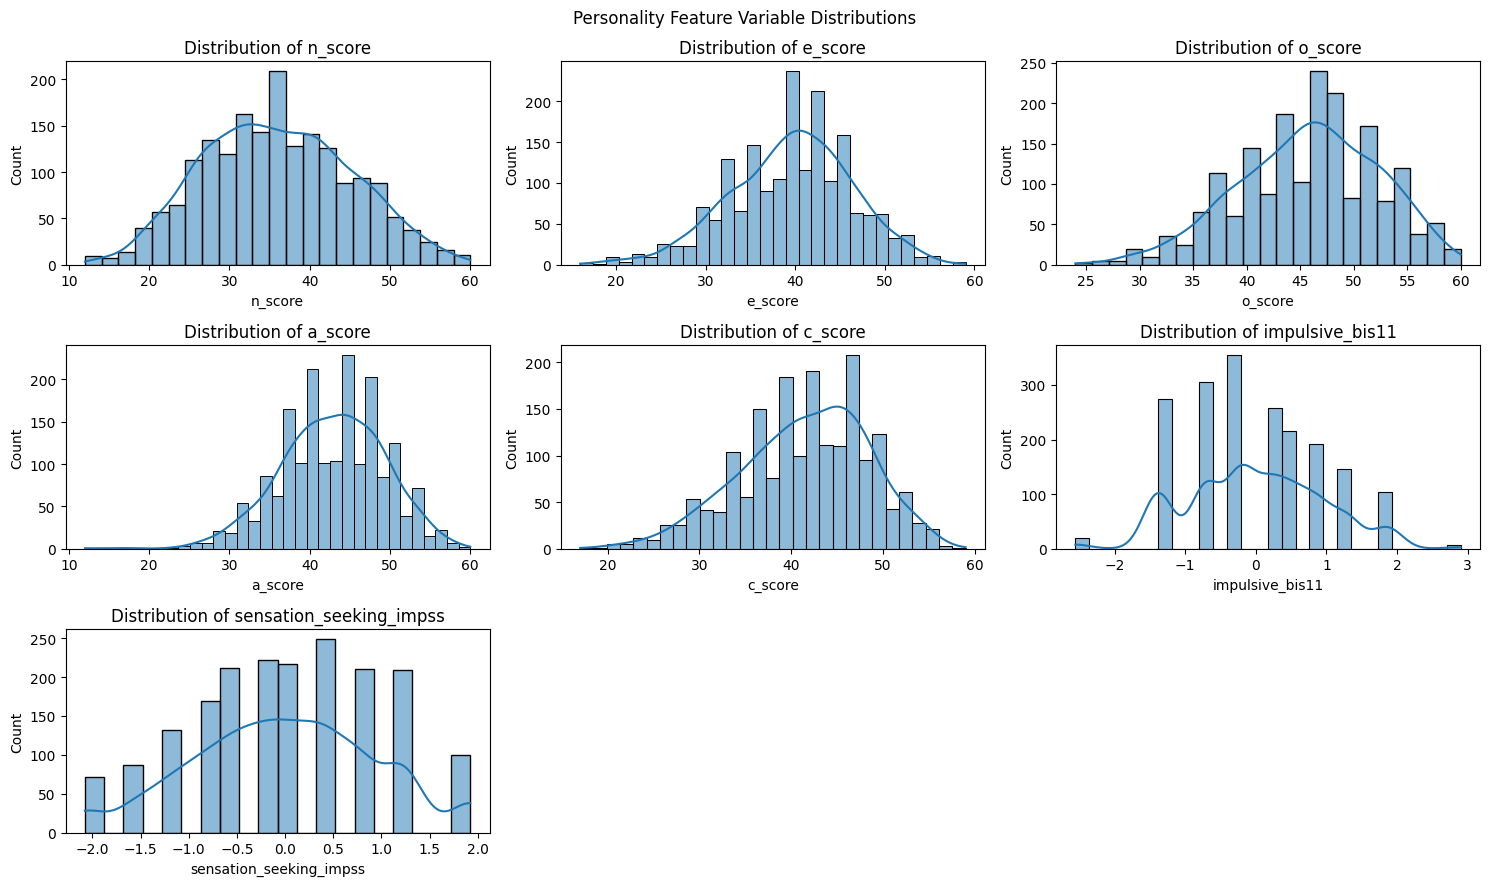

In [4]:
# NUMERIC FEATURES

# Set grid dimensions of visualizations
n_cols = 3
n_numeric = len(personality_vars)
n_rows = math.ceil(n_numeric / n_cols)
# Create figure containing distribution visualizations!
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3*n_rows))
for i, col in enumerate(personality_vars):
    row, col_idx = divmod(i, n_cols)
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
# Hide empty plots
for j in range(i+1, n_rows * n_cols):
    row, col_idx = divmod(j, n_cols)
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    ax.axis('off')
    
plt.suptitle("Personality Feature Variable Distributions")
plt.tight_layout()
plt.show()

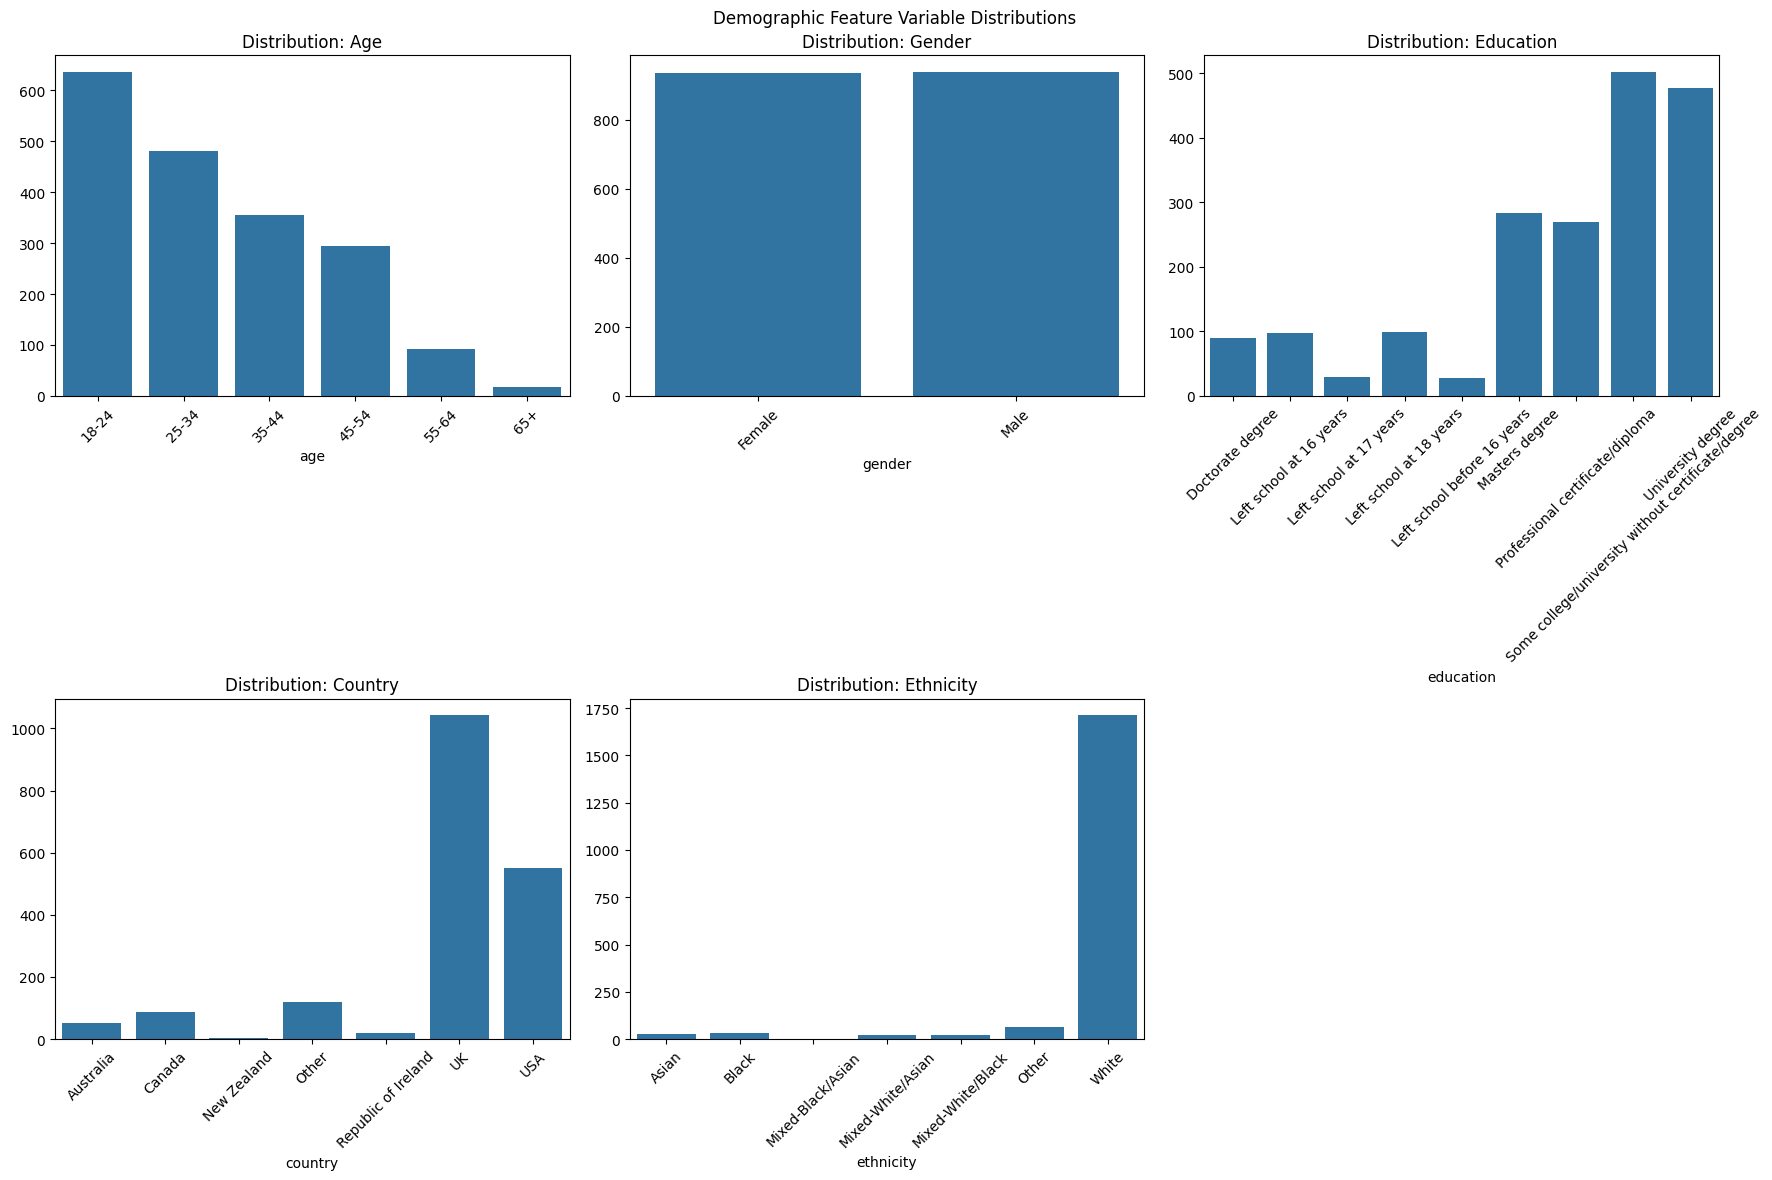

In [5]:
# CATEGORICAL

# Set grid dimensions of visualizations
n_cols = 3
n_demo = len(demographic_vars)
n_rows = math.ceil(n_demo / n_cols)
# Create figure containing distribution visualizations!
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
for i, var in enumerate(demographic_vars):
    row, col_idx = divmod(i, n_cols)
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    sns.countplot(x=var, data=df, ax=ax, order=sorted(df[var].unique()))
    ax.set_title(f'Distribution: {var.title()}')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('')
# Hide any empty subplots
for j in range(i+1, n_rows * n_cols):
    row, col_idx = divmod(j, n_cols)
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    ax.axis('off')

plt.suptitle("Demographic Feature Variable Distributions")
plt.tight_layout()
plt.show()

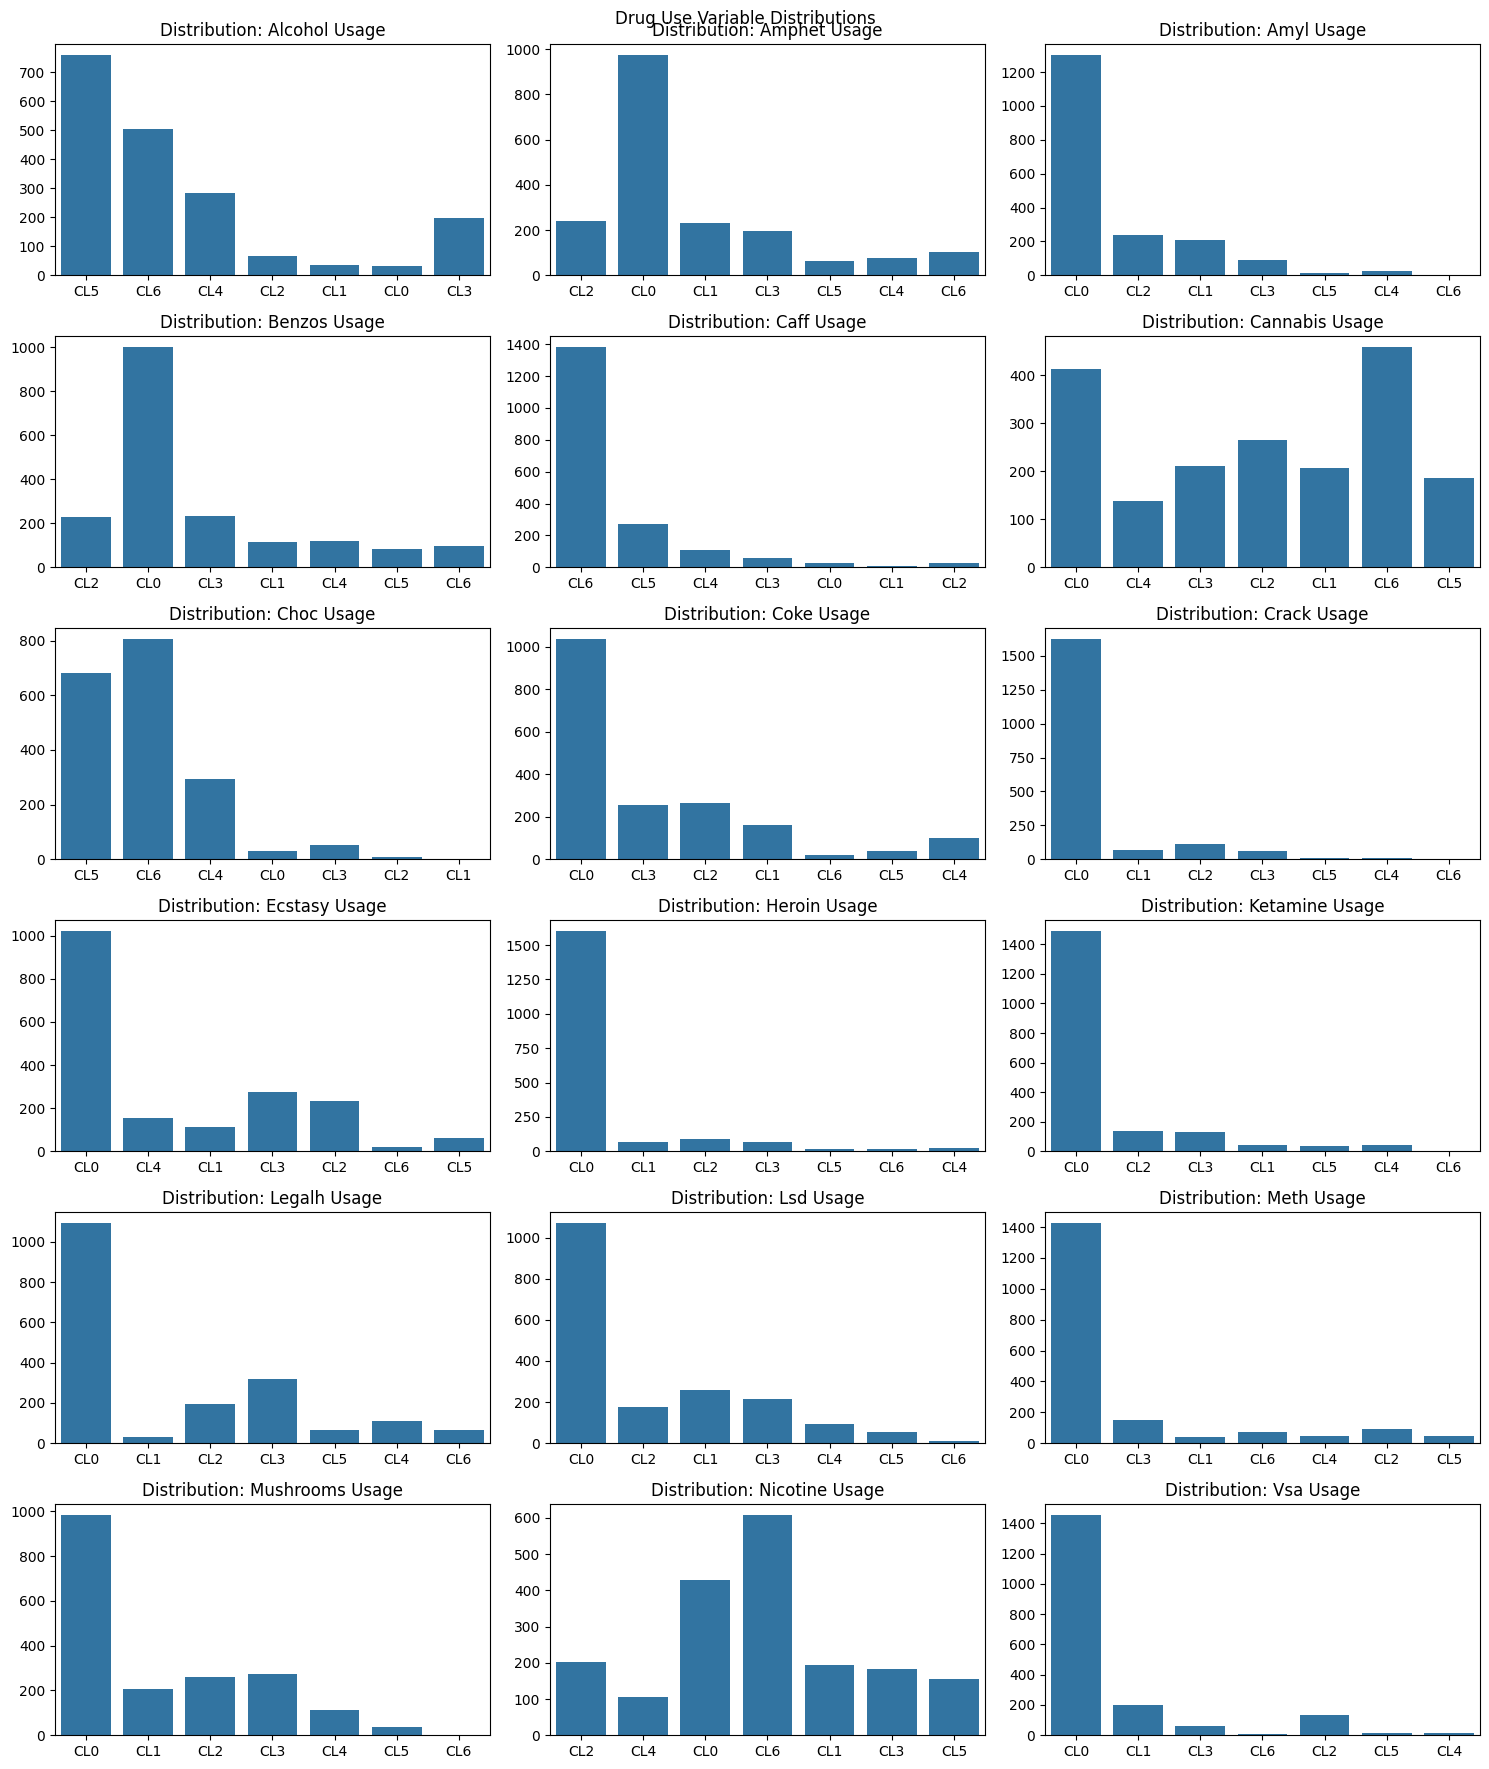

In [6]:
# TARGET FEATURES (DRUG USE)

# Set grid dimensions of visualizations
n_cols = 3
n_drugs = len(drug_vars)
n_rows = math.ceil(n_drugs / n_cols)
# Create figure containing distribution visualizations!
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3*n_rows))
for i, var in enumerate(drug_vars):
    row, col_idx = divmod(i, n_cols)
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    sns.countplot(x=var, data=df, ax=ax)
    ax.set_title(f'Distribution: {var.title()} Usage')
    ax.set_xlabel('')
    ax.set_ylabel('')
# Hide any empty subplots
for j in range(i+1, n_rows * n_cols):
    row, col_idx = divmod(j, n_cols)
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    ax.axis('off')

plt.suptitle("Drug Use Variable Distributions")
plt.tight_layout()
plt.show()

#### **Pairwise Correlation Matrix**

In [7]:
# CONVERT DRUG VALUES

# Handle CL[1-9] values used to indicate recency of drug use with a NON-LINEAR (exponential) scale to emphasize recency
drug_class_map = {f'CL{i}': 2**i for i in range(7)}
for drug in drug_vars:
    df[drug] = df[drug].map(drug_class_map) 

In [8]:
# DEFINE CORRELATION FUNCTIONS

# Cramer's V (Nominal-nominal pair)
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.values.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def cramers_v(a, b):
    confusion_matrix = pd.crosstab(a, b)
    return cramers_v_stat(confusion_matrix)

def correlation_ratio(categories, measurements):
    categories = pd.Categorical(categories)
    cat_num = len(categories.categories)
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i, cat in enumerate(categories.categories):
        cat_measures = measurements[categories == cat]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.mean(cat_measures) if len(cat_measures) > 0 else 0
    y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)
    numerator = np.sum(n_array * (y_avg_array - y_total_avg) ** 2)
    denominator = np.sum((measurements - y_total_avg) ** 2)
    if denominator == 0:
        return 0.0
    else:
        return np.sqrt(numerator / denominator)

In [9]:
# BUILD MATRIX

matrix_vars = nominal_vars + ordinal_vars + personality_vars
corr_matrix = pd.DataFrame(np.nan, index=matrix_vars, columns=matrix_vars)
strong_c = 0
var_s1 = var_s2 = ""
# Fill matrix with values
for i, var1 in enumerate(matrix_vars):
    for j, var2 in enumerate(matrix_vars):
        if i > j:
            continue  # Fill upper triangle only
        if var1 == var2:
            corr_matrix.loc[var1, var2] = 1.0
        elif var1 in personality_vars and var2 in personality_vars: # Use Kendall's tau for numeric-numeric
            tau, _ = kendalltau(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = tau
            if np.abs(tau) > strong_c:
                strong_c = tau
                var_s1, var_s2 = var1, var2
        elif (var1 in personality_vars and var2 in ordinal_vars) or (var2 in personality_vars and var1 in ordinal_vars):    # Use Kendall's tau for numeric-ordinal
            tau, _ = kendalltau(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = tau
            if np.abs(tau) > strong_c:
                strong_c = tau
                var_s1, var_s2 = var1, var2
        elif var1 in ordinal_vars and var2 in ordinal_vars: # Use Kendall's tau for ordinal-ordinal
            tau, _ = kendalltau(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = tau
            if np.abs(tau) > strong_c:
                strong_c = tau
                var_s1, var_s2 = var1, var2
        elif var1 in nominal_vars and var2 in nominal_vars: # Use Cramér's V for nominal-nominal
            v = cramers_v(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = v
            if np.abs(v) > strong_c:
                strong_c = v
                var_s1, var_s2 = var1, var2
        else:   # Mixed: nominal with numeric or ordinal (use correlation ratio)
            if var1 in nominal_vars:
                eta = correlation_ratio(df[var1], df[var2])
            else:
                eta = correlation_ratio(df[var2], df[var1])
            corr_matrix.loc[var2, var1] = eta
            if np.abs(eta) > strong_c:
                strong_c = eta
                var_s1, var_s2 = var1, var2
# Visualize complete pairwise correlation matrix
corr_matrix = corr_matrix.round(2)
print(f"Strongest correlation (+/-): \nVariable 1: {var_s1.title()}\nVariable 2: {var_s2.title()} \nValue: {strong_c:.3f}")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize": 5}, cmap="coolwarm", center=0, square=True)
plt.title("Mixed-Type Pairwise Correlation Matrix")
plt.tight_layout()
plt.show()

TypeError: Could not convert string '35-4418-2435-4465+35-4425-3455-6455-6455-6435-4455-6435-4435-4465+35-4425-3445-5425-3455-6455-6435-4425-3425-3445-5445-5465+45-5465+55-6455-6425-3435-4435-4435-4465+35-4445-5425-3445-5445-5425-3425-3435-4425-3445-5425-3445-5425-3425-3435-4435-4425-3435-4425-3445-5445-5445-5445-5435-4425-3435-4445-5445-5425-3435-4445-5435-4445-5435-4435-4425-3418-2435-4435-4435-4445-5425-3425-3425-3425-3425-3418-2445-5435-4435-4455-6435-4435-4445-5435-4445-5435-4418-2435-4435-4455-6445-5418-2455-6425-3445-5425-3455-6455-6425-3445-5418-2435-4425-3435-4418-2435-4435-4425-3445-5425-3445-5425-3425-3425-3425-3435-4418-2425-3435-4445-5435-4445-5445-5435-4465+25-3425-3425-3425-3425-3418-2445-5435-4425-3418-2425-3425-3425-3445-5445-5435-4418-2445-5435-4418-2445-5455-6418-2435-4445-5435-4445-5445-5425-3435-4445-5445-5445-5445-5425-3435-4435-4445-5425-3418-2465+35-4435-4425-3435-4455-6445-5445-5435-4445-5418-2445-5425-3418-2445-5455-6425-3445-5445-5435-4418-2425-3435-4425-3445-5455-6418-2465+25-3445-5445-5445-5435-4455-6455-6418-2435-4435-4445-5435-4425-3445-5435-4445-5435-4435-4445-5425-3435-4418-2455-6445-5425-3445-5435-4445-5445-5435-4425-3435-4425-3435-4425-3425-3418-2445-5435-4435-4425-3435-4425-3435-4445-5425-3425-3445-5418-2425-3425-3418-2435-4418-2425-3445-5445-5425-3418-2418-2418-2435-4418-2435-4418-2418-2418-2418-2418-2445-5418-2418-2435-4455-6445-5435-4425-3425-3435-4425-3435-4445-5435-4445-5455-6435-4425-3455-6435-4445-5418-2435-4425-3435-4445-5435-4445-5425-3418-2435-4425-3418-2445-5435-4445-5445-5425-3418-2435-4445-5425-3425-3418-2435-4418-2425-3425-3445-5418-2425-3418-2445-5418-2435-4435-4425-3445-5445-5418-2435-4435-4418-2455-6435-4425-3425-3445-5418-2435-4435-4418-2425-3455-6435-4435-4455-6445-5445-5435-4455-6455-6425-3425-3435-4445-5425-3435-4445-5435-4435-4425-3445-5435-4418-2418-2425-3435-4445-5435-4418-2425-3418-2435-4425-3445-5435-4425-3418-2425-3425-3425-3418-2418-2418-2435-4435-4418-2445-5455-6425-3445-5435-4445-5435-4435-4418-2425-3418-2435-4425-3435-4425-3425-3435-4418-2425-3418-2445-5435-4425-3425-3435-4435-4425-3425-3418-2418-2425-3418-2418-2418-2445-5418-2418-2418-2418-2418-2425-3435-4445-5418-2418-2445-5418-2425-3418-2425-3425-3445-5425-3425-3418-2418-2418-2418-2418-2418-2418-2425-3418-2425-3418-2418-2418-2425-3418-2418-2425-3418-2418-2425-3435-4425-3418-2418-2425-3418-2418-2425-3418-2418-2418-2418-2418-2425-3418-2425-3418-2425-3418-2418-2425-3418-2445-5425-3418-2418-2435-4435-4445-5425-3425-3425-3445-5418-2418-2418-2418-2435-4418-2418-2418-2435-4418-2418-2418-2418-2435-4418-2435-4425-3425-3418-2418-2425-3435-4445-5418-2418-2435-4425-3425-3418-2435-4435-4425-3435-4425-3418-2418-2418-2418-2418-2418-2425-3425-3418-2445-5425-3418-2418-2418-2418-2418-2425-3425-3418-2425-3425-3425-3425-3418-2425-3418-2445-5435-4455-6418-2418-2425-3425-3435-4418-2425-3425-3425-3425-3455-6418-2425-3418-2418-2435-4425-3418-2418-2418-2418-2425-3418-2418-2418-2445-5418-2445-5435-4425-3445-5425-3445-5445-5445-5445-5435-4445-5435-4435-4425-3445-5435-4425-3425-3445-5445-5425-3425-3445-5425-3435-4425-3435-4435-4425-3425-3455-6435-4435-4445-5425-3435-4418-2418-2418-2435-4418-2425-3418-2418-2435-4435-4418-2418-2425-3425-3418-2435-4418-2425-3418-2418-2418-2418-2418-2425-3418-2418-2418-2435-4418-2418-2418-2418-2418-2418-2418-2425-3435-4418-2418-2425-3425-3425-3425-3425-3418-2418-2445-5425-3435-4425-3425-3425-3425-3418-2425-3425-3425-3425-3425-3418-2425-3425-3425-3425-3425-3425-3425-3425-3425-3418-2425-3425-3418-2418-2418-2445-5425-3425-3455-6455-6435-4445-5425-3435-4435-4445-5425-3425-3425-3418-2425-3425-3418-2425-3445-5425-3425-3418-2435-4425-3418-2455-6425-3418-2425-3425-3435-4425-3445-5445-5425-3425-3425-3425-3425-3418-2445-5418-2418-2435-4445-5418-2418-2425-3418-2425-3435-4418-2418-2418-2418-2418-2425-3425-3455-6445-5445-5418-2425-3455-6418-2425-3435-4445-5435-4445-5435-4445-5425-3418-2425-3445-5435-4435-4425-3445-5445-5435-4445-5435-4435-4425-3435-4435-4435-4445-5445-5435-4425-3425-3455-6435-4425-3425-3425-3455-6425-3425-3435-4435-4425-3445-5425-3435-4435-4435-4425-3425-3425-3445-5435-4435-4445-5418-2445-5445-5445-5435-4445-5425-3445-5425-3425-3425-3425-3425-3435-4418-2445-5435-4418-2425-3425-3425-3425-3435-4425-3425-3418-2445-5418-2418-2445-5418-2435-4425-3425-3425-3425-3425-3445-5425-3425-3418-2435-4445-5435-4425-3435-4435-4445-5435-4425-3425-3425-3445-5425-3425-3418-2425-3445-5425-3455-6425-3445-5425-3435-4455-6425-3435-4445-5425-3425-3425-3418-2445-5435-4418-2425-3425-3425-3435-4425-3418-2418-2445-5418-2418-2425-3425-3425-3445-5435-4418-2435-4435-4418-2425-3435-4418-2418-2425-3445-5418-2425-3425-3425-3425-3435-4435-4435-4435-4425-3455-6418-2418-2425-3425-3455-6425-3418-2418-2418-2418-2425-3418-2425-3418-24' to numeric

In [ ]:
# Correlation Matrix Interpretation
# 1. There're no feature pairs with near-perfect correlation 
#    (abs[corr] >= 0.8), so we shouldn't drop features 
#    to avoid redundancy. Moreover, no features have an 
#    extremely strong relationship with many others, so we 
#    can/should keep most/all features.
# 2. Linear models will not generate great results with these
#    features, so we should progress as advised in lecture to
#    use tree-based or other non-linear models.